In [1013]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


df = pd.read_csv('train.csv', index_col='id')

#пример данных
df.sample(5)

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
197,1.010,7.38,577,25.7,75,2.31,0
141,1.008,7.38,577,26.0,87,1.03,0
290,1.028,5.98,840,26.1,395,7.64,0
337,1.010,6.27,225,8.8,64,1.27,1
168,1.017,5.66,702,20.8,330,4.49,1


In [1014]:

numeric_data = df.select_dtypes(include=np.number).columns.tolist()
categoric_data = df.select_dtypes(include=['object', 'category']).columns.tolist()

print('numeric: ', *numeric_data, sep = ', ')
print('categoric: ', *categoric_data)


numeric: , gravity, ph, osmo, cond, urea, calc, target
categoric: 


В датасете нет категориальных данных, только таргет

In [1015]:
#Подсчитаем количество пропусков и нулевых значений
for col in numeric_data:
    nan_count = df[col].isna().sum()
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    
    print(f'{col}: Nan: {nan_count}, Null: {null_count} Zero: {zero_count}')


gravity: Nan: 0, Null: 0 Zero: 0
ph: Nan: 0, Null: 0 Zero: 0
osmo: Nan: 0, Null: 0 Zero: 0
cond: Nan: 0, Null: 0 Zero: 0
urea: Nan: 0, Null: 0 Zero: 0
calc: Nan: 0, Null: 0 Zero: 0
target: Nan: 0, Null: 0 Zero: 230


Данные не имеют пропусков и нулевых значений, нет необходимости обработки пропусков

In [1016]:
"Основные статистические показатели для числовых данных:"
print(df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

          gravity          ph         osmo        cond        urea  \
count  414.000000  414.000000   414.000000  414.000000  414.000000   
mean     1.017894    5.955459   651.545894   21.437923  278.657005   
std      0.006675    0.642260   234.676567    7.514750  136.442249   
min      1.005000    4.760000   187.000000    5.100000   10.000000   
10%      1.008000    5.330000   343.600000   10.900000   95.000000   
25%      1.012000    5.530000   455.250000   15.500000  170.000000   
50%      1.018000    5.740000   679.500000   22.200000  277.000000   
75%      1.022000    6.280000   840.000000   27.600000  385.000000   
90%      1.025000    6.810000   925.200000   29.000000  443.000000   
max      1.040000    7.940000  1236.000000   38.000000  620.000000   

             calc      target  
count  414.000000  414.000000  
mean     4.114638    0.444444  
std      3.217641    0.497505  
min      0.170000    0.000000  
10%      1.053000    0.000000  
25%      1.450000    0.000000  
50%  

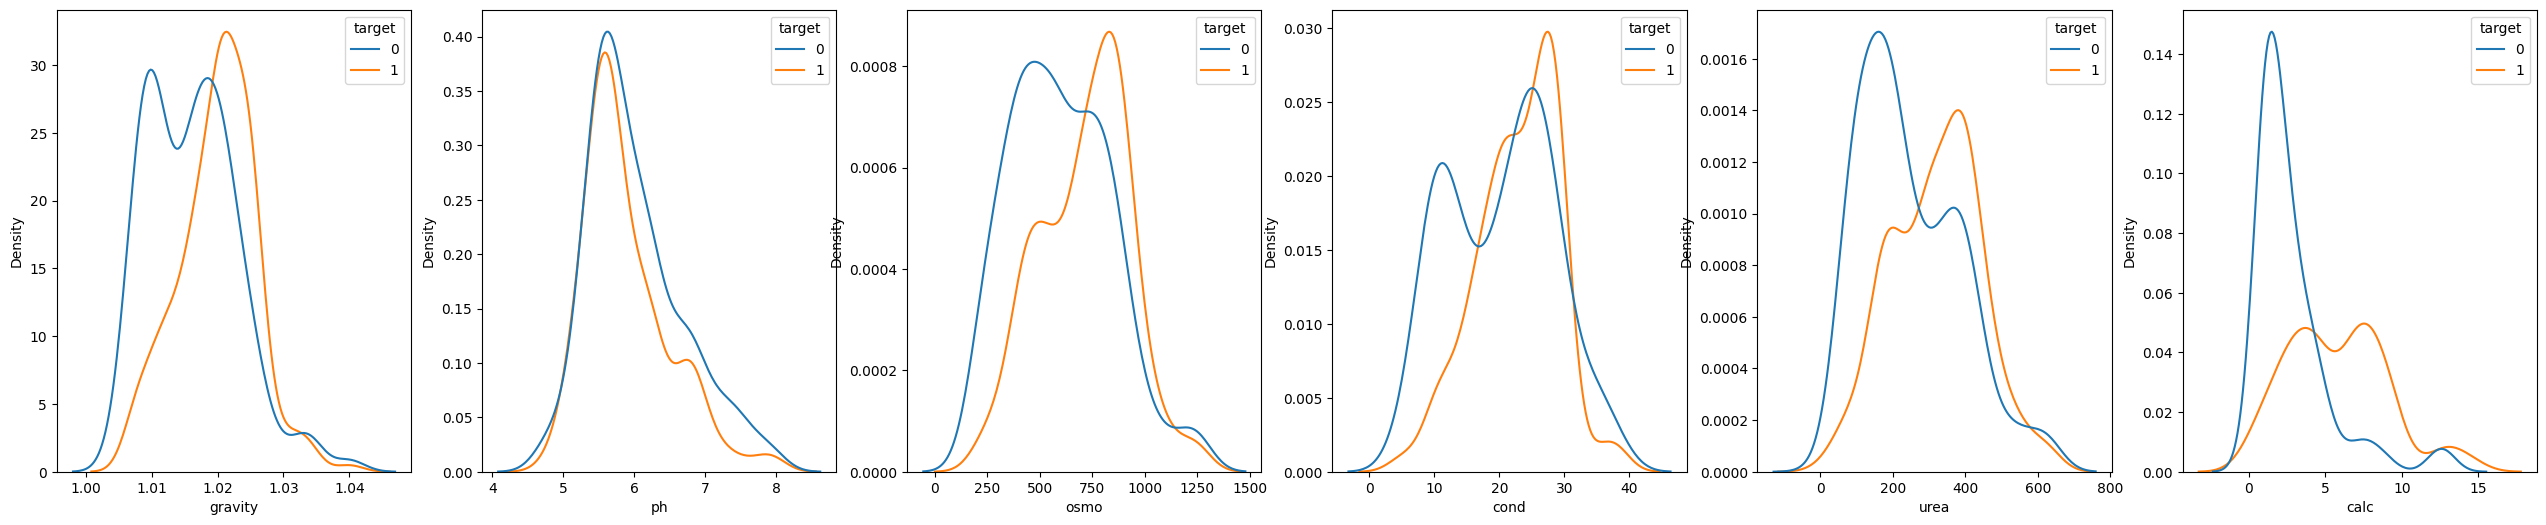

In [1017]:
fig, axes = plt.subplots(1, len(df.columns) - 1, figsize=(32, 6))

features = list(df.columns)
features.remove('target')

for idx, col in enumerate(features):
    sns.kdeplot(data=df, x=col, hue='target', ax=axes[idx])


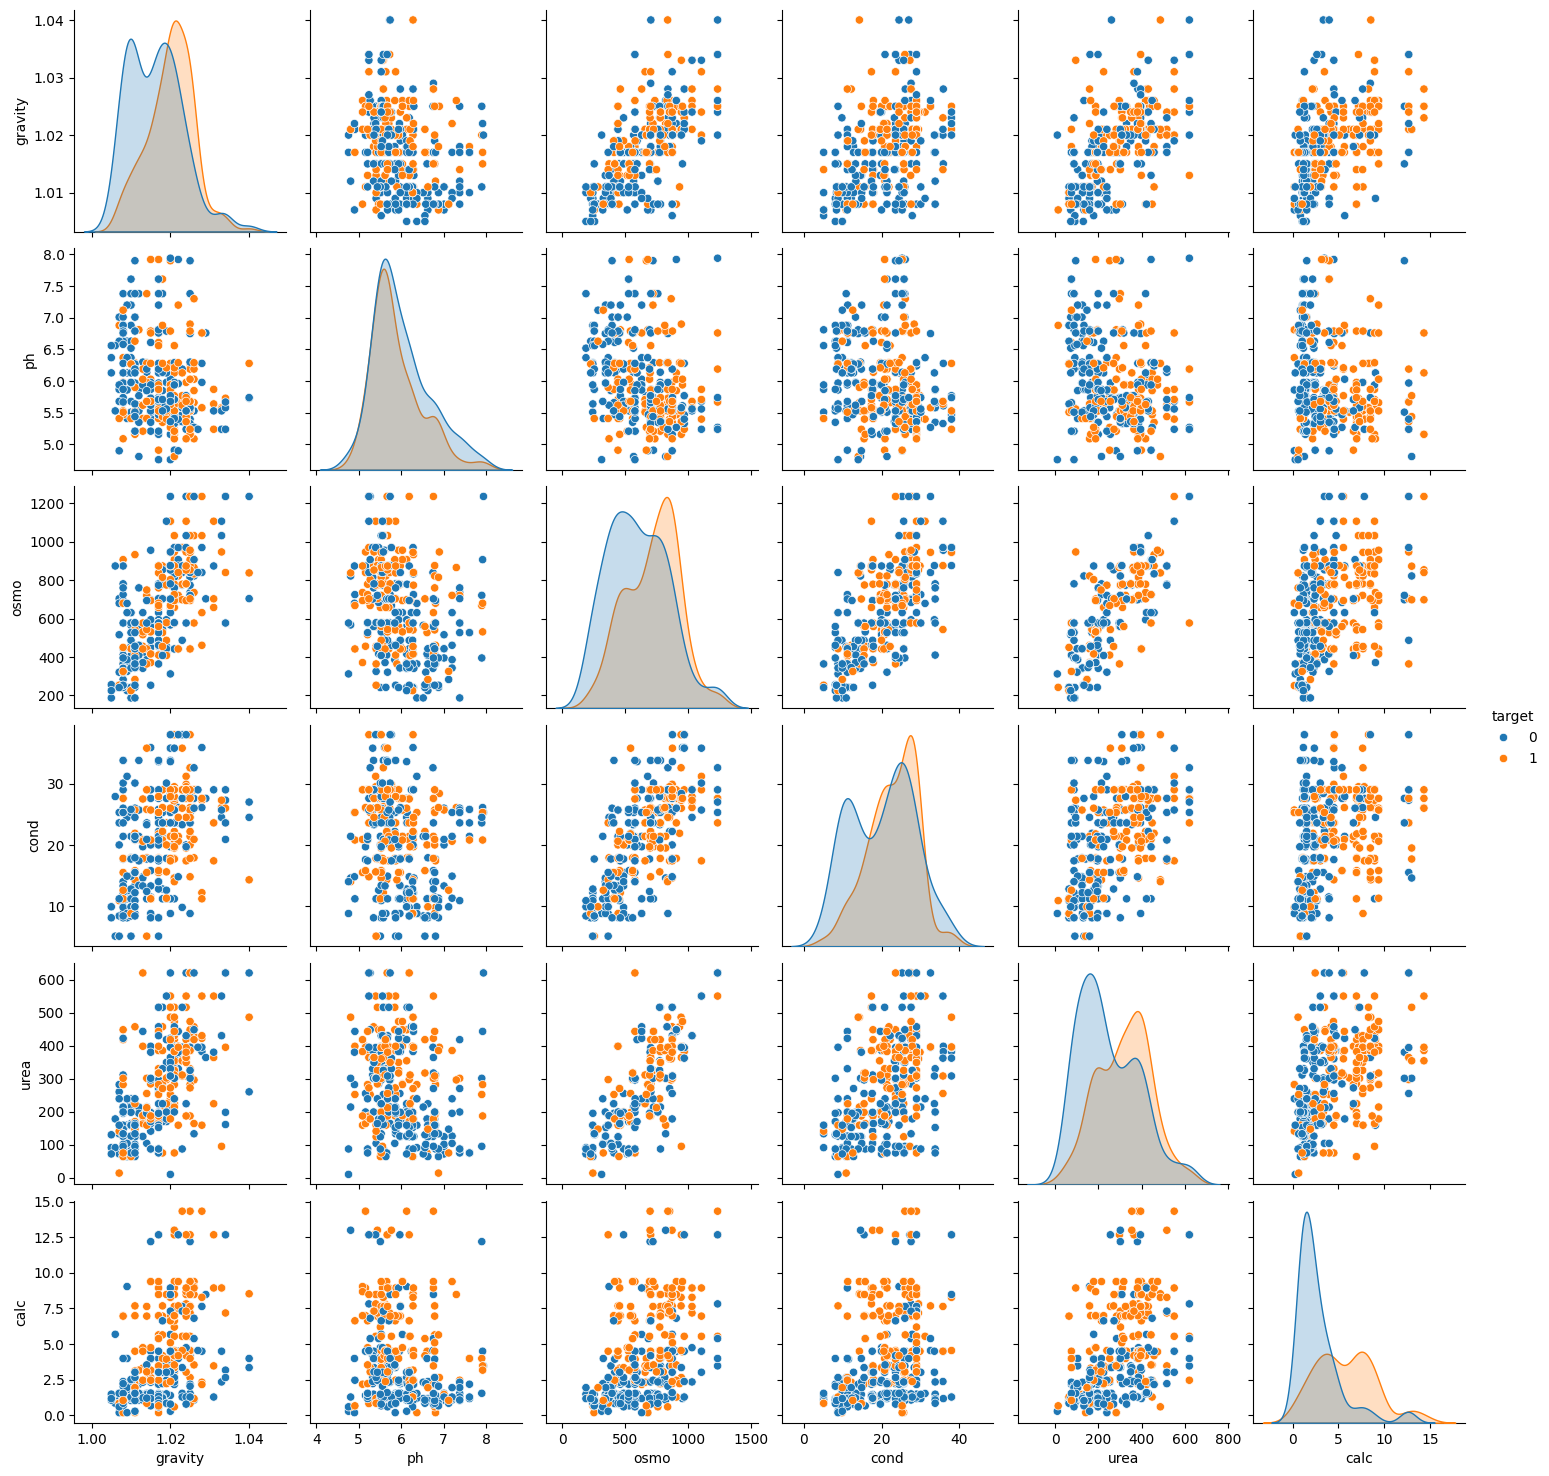

In [1018]:
sns.pairplot(df, hue='target')

<Axes: xlabel='target', ylabel='count'>

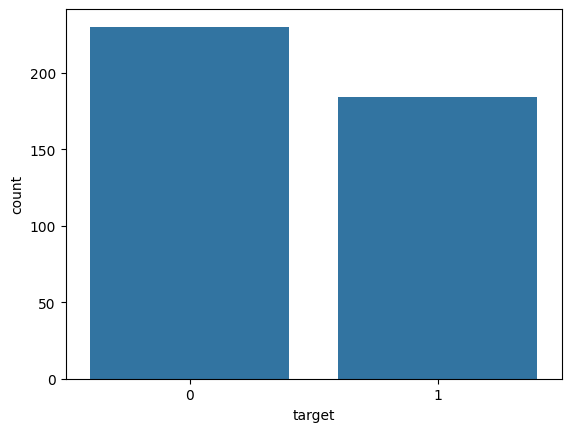

In [1019]:
#Распределение целевой переменной
sns.countplot(x='target', data=df)

<Axes: >

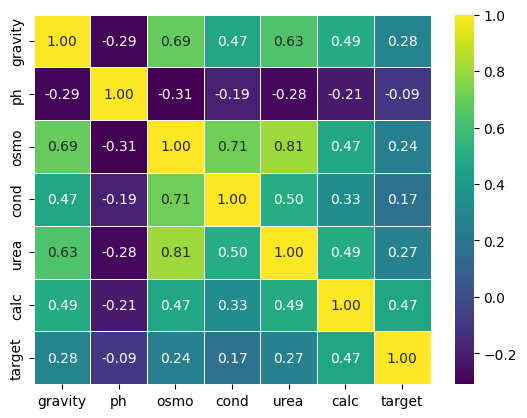

In [1020]:
#Корреляция признаков между собой
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)

Достаточно высокий коэффициент корреляции между gravity и osmo можно заменить на новую фичу

Таргет является категориальной колонкой. Изучим ее

In [1021]:
col = 'target'

nan_count = df[col].isna().sum()
null_count = df[col].isnull().sum()
zero_count = (df[col] == 0).sum()
unique_count = df[col].nunique()
total = df[col].count()
print(f"{col}: Total: {total} NaN: {nan_count}, Null: {null_count}, Zero: {zero_count}, Unique: {unique_count}")


target: Total: 414 NaN: 0, Null: 0, Zero: 230, Unique: 2


Все данные без пропусков, количество уникальных значений - 2, таким образом задача сводится к бинарной классификации.
Количество классов 0 - 230
Количество классов 1 - 194
Классы сбалансированы, нет необходимости в коррекции дисбаланса.

In [1022]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

#Для повторяемости результатов установим random state
np.random.seed(42)

In [1023]:
#Создаем новые фичи
df['grav_osmo'] = df['gravity'] / df['osmo']    
df['urea_osmo'] =  df['urea'] / df['osmo']   
df['grav_urea'] = df['gravity'] / df['urea']    


y = df['target']
X = df.drop(columns=['target', 'gravity', 'osmo', 'urea', 'ph'])


#делим на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.head())

     cond   calc  grav_osmo  urea_osmo  grav_urea
id                                               
192  17.4   1.40   0.002195   0.422993   0.005190
234  24.5   3.46   0.001445   0.383523   0.003767
5    28.4   2.64   0.001082   0.417107   0.002595
45   17.8   6.99   0.001294   0.536585   0.002411
245  23.6  12.68   0.001467   0.517781   0.002832


In [1024]:
#Создаем базовую модель
n_neighbors=3
model_cl = KNeighborsClassifier(n_neighbors = n_neighbors)
model_cl.fit(X_train, y_train) 

KNeighborsClassifier(n_neighbors=3)

In [1025]:
y_train_pred = model_cl.predict(X_train)
y_test_pred = model_cl.predict(X_test) 


In [1026]:

def print_report(y, y_pred, label: str):
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f'Accuracy {label}: {accuracy}')
    print(f'Confusion: {label}:\n{conf_matrix}')
    print(classification_report(y, y_pred))


In [1027]:

print_report(y_train, y_train_pred, 'train')
print_report(y_test, y_test_pred, 'test')


Accuracy train: 0.8308157099697885
Confusion: train:
[[164  21]
 [ 35 111]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       185
           1       0.84      0.76      0.80       146

    accuracy                           0.83       331
   macro avg       0.83      0.82      0.83       331
weighted avg       0.83      0.83      0.83       331

Accuracy test: 0.6867469879518072
Confusion: test:
[[34 11]
 [15 23]]
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        45
           1       0.68      0.61      0.64        38

    accuracy                           0.69        83
   macro avg       0.69      0.68      0.68        83
weighted avg       0.69      0.69      0.68        83



In [1028]:
# Создание пайплайна
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False)),  # Создание полиномиальных признаков
    ('scaler', StandardScaler()),  # нормализация данных
    ('knn', KNeighborsClassifier())  #модель KNN
])


In [1029]:
#Подберем параметры для лучшей модели
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan']
}

gs_knn = GridSearchCV(pipeline, param_grid=param_grid,
                       scoring='accuracy', n_jobs=-1, cv=5)

gs_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9]},
             scoring='accuracy')

In [1030]:
print(f'Гиперпараметры лучшей модели: {gs_knn.best_params_}')
print(f'Значение accuracy {gs_knn.best_score_}')

Гиперпараметры лучшей модели: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5}
Значение accuracy 0.7158299412030755


In [1031]:
#Обучаем модель с лучшими параметрами
gs_knn.fit(X_train, y_train) 


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9]},
             scoring='accuracy')

In [1032]:
y_train_pred = gs_knn.predict(X_train)
y_test_pred = gs_knn.predict(X_test) 


print_report(y_train, y_train_pred, 'train')
print_report(y_test, y_test_pred, 'test')


Accuracy train: 0.7734138972809668
Confusion: train:
[[150  35]
 [ 40 106]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       185
           1       0.75      0.73      0.74       146

    accuracy                           0.77       331
   macro avg       0.77      0.77      0.77       331
weighted avg       0.77      0.77      0.77       331

Accuracy test: 0.7590361445783133
Confusion: test:
[[37  8]
 [12 26]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        45
           1       0.76      0.68      0.72        38

    accuracy                           0.76        83
   macro avg       0.76      0.75      0.75        83
weighted avg       0.76      0.76      0.76        83



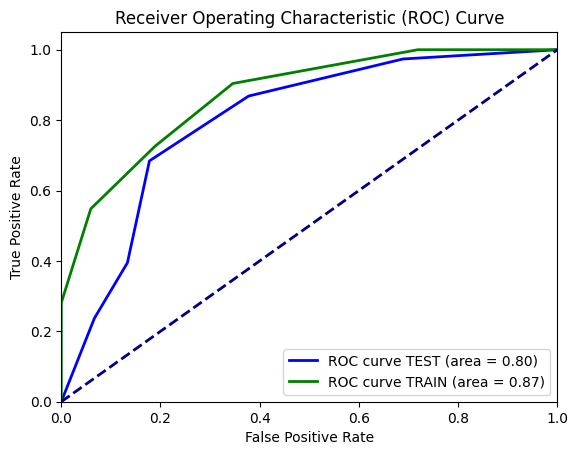

In [1033]:
from sklearn.metrics import roc_curve, auc

y_test_prob = gs_knn.predict_proba(X_test)[:,1]
y_train_prob = gs_knn.predict_proba(X_train)[:, 1]


fpr_test, tpr_test, thresholds = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Построение ROC кривой
plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve TEST (area = {roc_auc_test:.2f})')
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve TRAIN (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [1034]:
#Решение для Kaggle

df_test = pd.read_csv('test.csv', index_col='id')

df_test['grav_osmo'] = df_test['gravity'] / df_test['osmo']    
df_test['urea_osmo'] =  df_test['urea'] / df_test['osmo']   
df_test['grav_urea'] = df_test['gravity'] / df_test['urea']    

X = df_test.drop(columns=['gravity', 'osmo', 'urea', 'ph'])

y = gs_knn.predict(X.to_numpy())

res = pd.DataFrame()

res['target'] = y
res.index = df_test.index
res.to_csv('submission.csv')

d:\projects\ml algorithms\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
